### `Import the Main Libraries`

In [1]:
## Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Embeded Datasets
from sklearn import datasets

## Preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict

## Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

## Algorithm
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier

### `Load the Dataset and Look at the big Picture`

In [2]:
## Load the MNIST Dataset --> using the embeded version of data in sklearn
## You can download it manually and read it as CSV file
mnsit_dataset = datasets.fetch_openml('mnist_784', version=1)

In [3]:
## Check the keys of the Dataset
mnsit_dataset.keys()             ## each keys represent some information or data

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
## Let's create a DF 
## I will do it in my preferable fast way
df_mnist = pd.DataFrame(np.c_[mnsit_dataset['data'], mnsit_dataset['target']], 
                        columns=mnsit_dataset['feature_names']+['target'])

## check the head
df_mnist.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [5]:
## check info
df_mnist.info()   ## object --> take care --> to numerical values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to target
dtypes: object(785)
memory usage: 419.2+ MB


In [6]:
## convert to numerical values
df_mnist = df_mnist.astype(np.int32)   ## overwrite the DF

## check the info again
df_mnist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to target
dtypes: int32(785)
memory usage: 209.6 MB


### `Exploratory Data Analysis (EDA)`

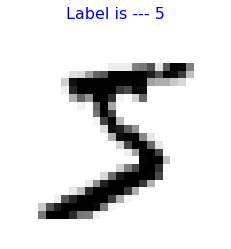

In [7]:
## Let's check some instances 
## first instance  --> take only the Features not the target
first_img = df_mnist.iloc[0, :]
first_img_feat = first_img[:-1].values.reshape(28, 28)  ## Features reshaped to be image (28, 28)
first_img_label = first_img[-1]                         ## target of the same instance


## Plotting the image -- using any method (PILLOW, Keras, Sklearn, Skimage, matplotlib (below))
plt.imshow(first_img_feat, cmap='binary')
plt.title(f'Label is --- {first_img_label}', fontsize=16, color='b')
plt.axis('off')
plt.show()   ## Right

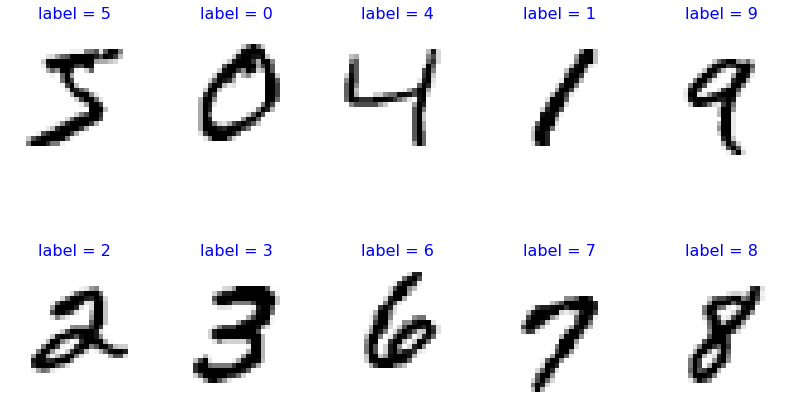

In [8]:
## We want to get an instance for each unique target and plot it
## Read the code carefully --> trace it line by line, point by point

target_values = df_mnist['target'].unique()

img_key_value = {}    ## to append in it
for key in target_values:
    img_key_value[key] = df_mnist[df_mnist['target']==target_values[key]].iloc[0][:-1].values.reshape(28, 28)
    

    
## Split the labels -- which are the keys of the dictionary
img_label = list(img_key_value.keys())

## Plotting
fig, ax = plt.subplots(2, 5, figsize=(14, 8))   ## 10 values

i = 0
for row in range(2):
    for col in range(5):
        plt.sca(ax[row, col])
        plt.title(f'label = {img_label[i]}', fontsize=16, color='b')   ## label 
        plt.imshow(img_key_value[i], cmap='binary')  ## image itself
        plt.axis('off')
        i+=1                       ## OK

### `Preprocessing`

In [9]:
## Split to Features and traget
X = df_mnist.drop(columns=['target'], axis=1)
y = df_mnist['target']

In [10]:
## No Imputing, No encoding
max_value = np.max(X.max(axis=0))
max_value

255

In [11]:
## Standardize by dividing by 255 to be range (0 - 1) instead of (0 - 255)
## You can split first to train, test and then divide by 255, or do the opposite thing here --> the same here --> WHY ?

## I will divide first then split the dataset to train, test
X = X / 255.

### `Split the Dataset`

In [12]:
## First 60000 to train, and the other to test, for validation I will use cross validation
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]   

## check the shapes
print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (60000, 784)
y_train shape --  (60000,)
X_test shape --  (10000, 784)
y_test shape --  (10000,)


### `Firstly, Binary Classification`

In [13]:
## Binary classification (True or 1 --> for target is 5) & (False or 0 --> for other target)
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

### `Build the Model`

### `SGDClassifier`

In [14]:
## Let's try SGD
sgd_clf = SGDClassifier(penalty=None, random_state=42)
sgd_clf.fit(X_train, y_train_5)    ## train for only binary classification (target is something or not) (True or False)

SGDClassifier(penalty=None, random_state=42)

In [15]:
## Validation --> Using Cross validation
sgd_acc_scores_valid = cross_val_score(estimator=sgd_clf, X=X_train, y=y_train_5, cv=5, scoring='accuracy', n_jobs=-1)

## Get the Mean and std
print('Mean of Accuracy Scores using SGD -- ', sgd_acc_scores_valid.mean())
print('Std of Accuracy Scores using SGD -- ', sgd_acc_scores_valid.std())

Mean of Accuracy Scores using SGD --  0.9676
Std of Accuracy Scores using SGD --  0.001664498589832831


* > `It seems that the Accuracy is very high --> something wrong -----------> talking with Instructor and spend much time here -----> Why is this happening ?`

### `Other Metrics`

In [16]:
## Predict for validation --> using (predict) method
y_pred_sgd_valid = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=5, n_jobs=-1, method='predict')

confmat_sgd =>
 [[53578  1001]
 [  943  4478]]
------------------------------------------------------------


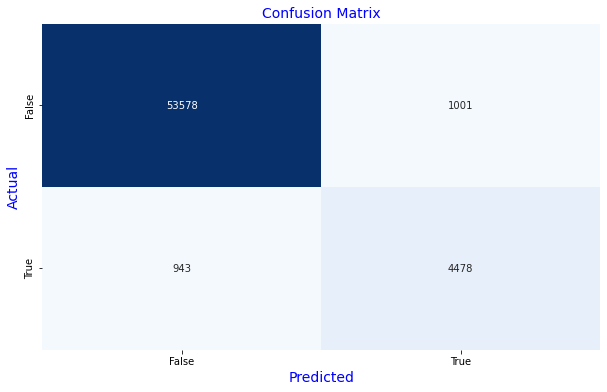

In [17]:
## confusion Matrix
confmat_sgd = confusion_matrix(y_train_5, y_pred_sgd_valid)
print('confmat_sgd =>\n', confmat_sgd)

print('--'*30)


## Plotting as a HeatMap
plt.figure(figsize=(10, 6))
sns.heatmap(confmat_sgd, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')
plt.xticks(ticks=np.arange(2) + 0.5, labels=['False', 'True'])   ## to only handle the names in proper way
plt.yticks(ticks=np.arange(2) + 0.5, labels=['False', 'True'])   ## to only handle the names in proper way
plt.xlabel('Predicted', fontsize=14, color='b')
plt.ylabel('Actual', fontsize=14, color='b')
plt.title('Confusion Matrix', fontsize=14, color='b')
plt.show()

In [18]:
## Precision and Recall score
precison_score_sgd = precision_score(y_train_5, y_pred_sgd_valid)
print('Precison Score using SGD =>', precison_score_sgd)

print('---'*20)

recall_score_sgd = recall_score(y_train_5, y_pred_sgd_valid)
print('Recall Score using SGD =>', recall_score_sgd)

print('---'*20)

class_repo_sgd = classification_report(y_train_5, y_pred_sgd_valid)
print('Classifcation Report using SGD => \n', class_repo_sgd)

Precison Score using SGD => 0.8173024274502646
------------------------------------------------------------
Recall Score using SGD => 0.8260468548238332
------------------------------------------------------------
Classifcation Report using SGD => 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98     54579
        True       0.82      0.83      0.82      5421

    accuracy                           0.97     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.97      0.97      0.97     60000



In [19]:
## to get f1_score
f1_score_sgd = f1_score(y_train_5, y_pred_sgd_valid)
print('F1 Score using SGD =>', f1_score_sgd)

F1 Score using SGD => 0.821651376146789


### `Precision/Recall Tradeoff`

* `Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.` 
* `Instead of calling the classifier’s predict() method.`
* `You can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.`

In [20]:
## To get the score (that will be compared to threshold)

## Using the (decision_function) provided in sklearn
y_scores_sgd = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=5, n_jobs=-1, method='decision_function')

In [21]:
## Using these scores to get precision and recall at different thresholds
precision_vals, recall_vals, thresholds_vals = precision_recall_curve(y_train_5, y_scores_sgd)

#### `Precision & Recall & thresholds Curve`

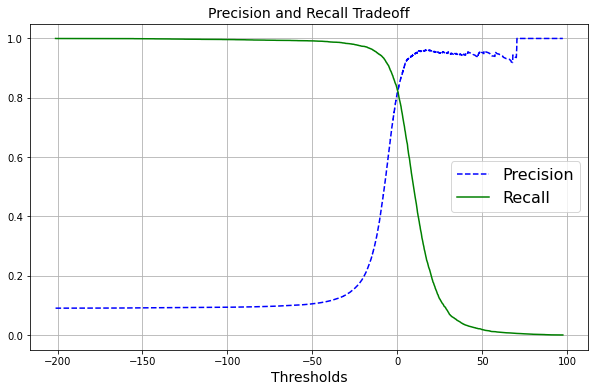

In [22]:
## Precision and Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds_vals, precision_vals[:-1], 'b--', label='Precision')
plt.plot(thresholds_vals, recall_vals[:-1], 'g-', label='Recall')
plt.title('Precision and Recall Tradeoff', fontsize=14)
plt.xlabel('Thresholds', fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.show()

In [23]:
## Try to change threshold from 0 to any number --> 
## more than 0 --> precision increases and recall decreases
## less than 0 --> precision decreases and recall increases

## Increase threshold to be more than 0
precision_score_50 = precision_score(y_train_5, y_scores_sgd>50)
recall_score_50 = recall_score(y_train_5, y_scores_sgd>50)
print('Precison Score using SGD at threshold=50 ---- ', precision_score_50)
print('Recall Score using SGD at threshold=50 ---- ', recall_score_50)

print('---'*30)

## Decrease threshold to be less than 0
precision_score_50_minus = precision_score(y_train_5, y_scores_sgd>-50)
recall_score_50_minus = recall_score(y_train_5, y_scores_sgd>-50)
print('Precison Score using SGD at threshold=-50 ---- ', precision_score_50_minus)
print('Recall Score using SGD at threshold=-50 ---- ', recall_score_50_minus)

Precison Score using SGD at threshold=50 ----  0.9519230769230769
Recall Score using SGD at threshold=50 ----  0.018262313226342003
------------------------------------------------------------------------------------------
Precison Score using SGD at threshold=-50 ----  0.10532708998648145
Recall Score using SGD at threshold=-50 ----  0.991698948533481


In [24]:
## What about choosing precision to be specific value --> Let's say, We want precision to be more than 90%
## OK
threshold_prec_90 = thresholds_vals[np.argmax(precision_vals >= 0.90)]   ## Threshold which achieve precision >= 90%
print(f'Threshold which achieve Precision >= 90% ---- {threshold_prec_90:.4f}')

## Prediction at specific threshold which achieve precision >= 90%
y_pred_prec_90 = (y_scores_sgd >= threshold_prec_90)
print(f'Precison Score using SGD at threshold={threshold_prec_90:.3f} ---- {precision_score(y_train_5, y_pred_prec_90):.3f}')
print(f'Recall Score using SGD at threshold={threshold_prec_90:.3f} ---- {recall_score(y_train_5, y_pred_prec_90):.3f}')

Threshold which achieve Precision >= 90% ---- 3.7192
Precison Score using SGD at threshold=3.719 ---- 0.900
Recall Score using SGD at threshold=3.719 ---- 0.714


#### `Precision & Recall  Curve`

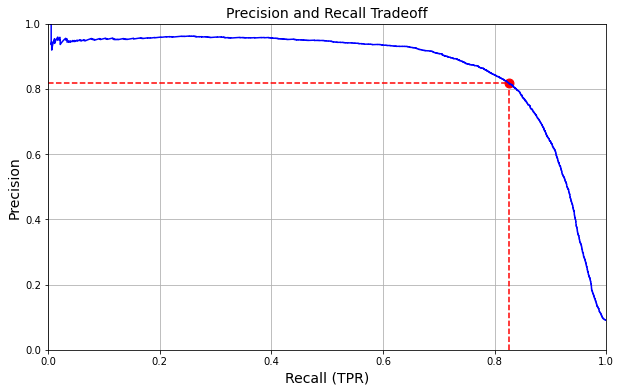

In [25]:
## Precision and Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, 'b-')
plt.title('Precision and Recall Tradeoff', fontsize=14)
plt.xlabel('Recall (TPR)', fontsize=14)
plt.ylabel('Precision', fontsize=14)
## plotting the point at threshold=0 -- whis is our case here
plt.scatter(recall_score_sgd, precison_score_sgd, color='r', marker='o', s=80)
plt.vlines(ymin=0, ymax=precison_score_sgd, x=recall_score_sgd, linestyles='--', color='r')
plt.hlines(xmin=0, xmax=recall_score_sgd, y=precison_score_sgd, linestyles='--', color='r')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### `ROC Curve`
`Receiver Operating Characteristic  (ROC)`

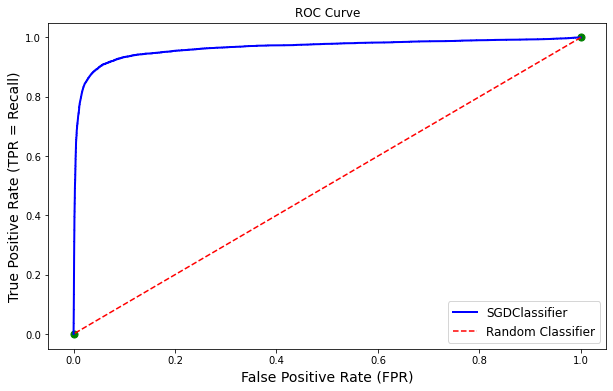

In [26]:
## ROC Curve --> Binary Classification only
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train_5, y_scores_sgd)


## Plotting
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgd, tpr_sgd, linewidth=2, color='b', label='SGDClassifier')
plt.plot([1, 0], [1, 0], 'r--', label='Random Classifier')
plt.scatter(0, 0, color='g', s=50)
plt.scatter(1, 1, color='g', s=50)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR = Recall)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [27]:
## To get the AUC (Area under Curve) 
auc_sgd = roc_auc_score(y_train_5, y_scores_sgd)
print('Area Under Curve using SGD -- ', auc_sgd)

Area Under Curve using SGD --  0.9653085940230138


### `KNN`
`Let's try another algorithm --- KNN`

In [28]:
## intialize knn and fit and calculate cross_validation, get the scores, get different scores (precision, recall .......)
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train_5)

KNeighborsClassifier()

In [29]:
## Get the croos validation scores --> accuracy
knn_acc_scores_valid = cross_val_score(knn_clf, X_train, y_train_5, cv=5, scoring='accuracy', n_jobs=-1)


## Get the Mean and std
print('Mean of Accuracy Scores using KNN -- ', knn_acc_scores_valid.mean())
print('Std of Accuracy Scores using KNN -- ', knn_acc_scores_valid.std())

Mean of Accuracy Scores using KNN --  0.9934666666666667
Std of Accuracy Scores using KNN --  0.0008508166012067002


In [30]:
## Predict for validation --> using (predict) method
y_pred_knn_valid = cross_val_predict(estimator=knn_clf, X=X_train, y=y_train_5, cv=5, n_jobs=-1, method='predict')

confmat_knn =>
 [[54428   151]
 [  241  5180]]
------------------------------------------------------------


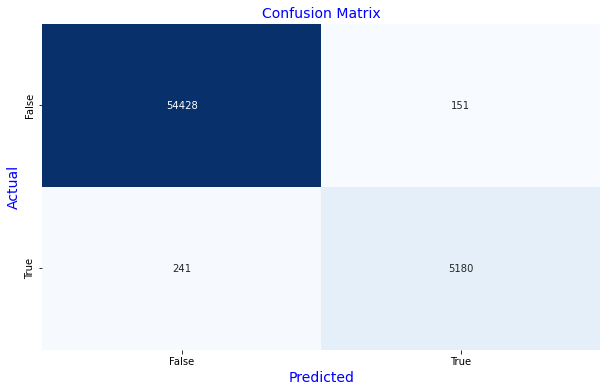

In [31]:
## confusion Matrix
confmat_knn = confusion_matrix(y_train_5, y_pred_knn_valid)
print('confmat_knn =>\n', confmat_knn)

print('--'*30)


## Plotting as a HeatMap
plt.figure(figsize=(10, 6))
sns.heatmap(confmat_knn, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')
plt.xticks(ticks=np.arange(2) + 0.5, labels=['False', 'True'])   ## to only handle the names in proper way
plt.yticks(ticks=np.arange(2) + 0.5, labels=['False', 'True'])   ## to only handle the names in proper way
plt.xlabel('Predicted', fontsize=14, color='b')
plt.ylabel('Actual', fontsize=14, color='b')
plt.title('Confusion Matrix', fontsize=14, color='b')
plt.show()

In [32]:
## Precision and Recall score
precison_score_knn = precision_score(y_train_5, y_pred_knn_valid)
print('Precison Score using KNN =>', precison_score_knn)

print('---'*20)

recall_score_knn = recall_score(y_train_5, y_pred_knn_valid)
print('Recall Score using KNN =>', recall_score_knn)

print('---'*20)

class_repo_knn = classification_report(y_train_5, y_pred_knn_valid)
print('Classifcation Report using KNN => \n', class_repo_knn)

Precison Score using KNN => 0.9716751078596886
------------------------------------------------------------
Recall Score using KNN => 0.955543257701531
------------------------------------------------------------
Classifcation Report using KNN => 
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     54579
        True       0.97      0.96      0.96      5421

    accuracy                           0.99     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [33]:
##  Get scores using KNN
## take care of Method (decision_function & predict_proba) ---> Ask your Instructor
y_scores_knn = cross_val_predict(knn_clf, X_train, y_train_5, cv=5, n_jobs=-1, method='predict_proba')

In [34]:
## Take only the column for (True) probability, complete all steps
y_scores_knn = y_scores_knn[:, 1]

## ROC using KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train_5, y_scores_knn)

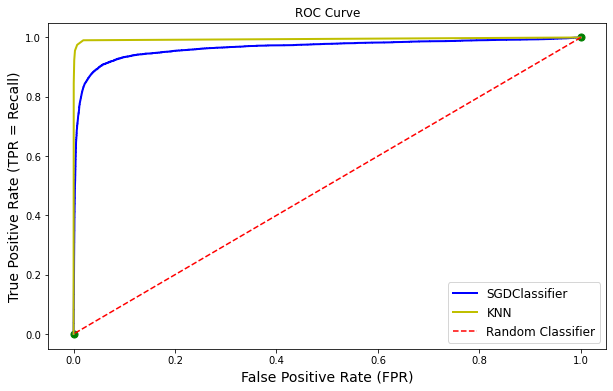

In [35]:
## Comapring between AUC for both Models (SGD & KNN)

## Plotting the ROC for KNN & SGD
## Plotting
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgd, tpr_sgd, linewidth=2, color='b', label='SGDClassifier')
plt.plot(fpr_knn, tpr_knn, linewidth=2, color='y', label='KNN')
plt.plot([1, 0], [1, 0], 'r--', label='Random Classifier')
plt.scatter(0, 0, color='g', s=50)
plt.scatter(1, 1, color='g', s=50)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR = Recall)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [36]:
## AUC for KNN
auc_knn = roc_auc_score(y_train_5, y_scores_knn)
print('Area Under Curve using KNN -- ', auc_knn)

Area Under Curve using KNN --  0.9946272968644606


#### `You can complete the steps for Precision and Recall and for any Algorithm`

----------

### `MultiClass Classification`
`## Now time for classification for MNIST Dataset as Multiclass `

In [37]:
## Try SGDClassifier --> Default in sklearn is OVA, I will here use OVO (only for showing)
sgd_multi_clf = OneVsOneClassifier(SGDClassifier(penalty=None, random_state=42))  ## using OVO
sgd_multi_clf.fit(X_train.values, y_train)

OneVsOneClassifier(estimator=SGDClassifier(penalty=None, random_state=42))

In [38]:
## If you want to test the Model -> If we predict an Instance, it will produce 10 scores (we have 10 categories)
## And the final result is the max score and its index which represent the category 

## Try on the first element in the Dataset
first_scores = sgd_multi_clf.decision_function([X_train.iloc[0]])   ## the max score here is 9.333 --> which is 5
print('Scores of first Instance is --- \n', first_scores)

print('--'*30)

first_pred = sgd_multi_clf.predict([X_train.iloc[0]])
print('Prediction of the first Instance is ---- ', first_pred[0])

Scores of first Instance is --- 
 [[ 1.66689021  3.66725898  6.3328495   8.3332049  -0.33320603  9.33317776
   1.66684254  2.66779186  5.33298189  6.33265104]]
------------------------------------------------------------
Prediction of the first Instance is ----  5


### `I will always use OVR (Default in sklearn) except with SVM, I will use (OVO)`

`I will show how to get all the above Results but with Multiclass --- Let's GO`

#### `SGDClassifier for Multiclass`

In [39]:
## Intialize a SGDClassifier, Train and get the validation scores, vaidation prediction and scores
sgd_clf_2 = SGDClassifier(penalty=None, random_state=425)
sgd_clf_2.fit(X_train, y_train)  ## train

SGDClassifier(penalty=None, random_state=425)

In [40]:
## Cross Validation
## Accuracy here is meaningfull metric, not like the above for binary ----> Why ?
sgd_acc_scores_valid_2 = cross_val_score(sgd_clf_2, X_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')

print('Mean of Cross Validation using SGD -- ', sgd_acc_scores_valid_2.mean())
print('Std of Cross Validation using SGD -- ', sgd_acc_scores_valid_2.std())

Mean of Cross Validation using SGD --  0.8939499999999999
Std of Cross Validation using SGD --  0.0032590898524997064


In [41]:
## Predict for validation --> using (predict) method
y_pred_sgd_valid_2 = cross_val_predict(sgd_clf_2, X_train, y_train, cv=3, n_jobs=-1, method='predict')

confmat_sgd_2 =>
 [[5660    1   41   28    9   41   29    7   88   19]
 [   2 6447   48   42    6   55    5    7  101   29]
 [  45   57 5257  144   54   50   75   60  194   22]
 [  27   28  186 5276   12  263   19   58  162  100]
 [   9   18   55   30 5266   56   42   37   92  237]
 [  47   19   42  226   61 4609  105   24  209   79]
 [  42   11   84   22   37  142 5495    7   72    6]
 [  19   14   66   50   62   28    5 5730   44  247]
 [  40  101  106  219   50  245   48   20 4870  152]
 [  22   28   18  116  230  103    3  286  116 5027]]
------------------------------------------------------------


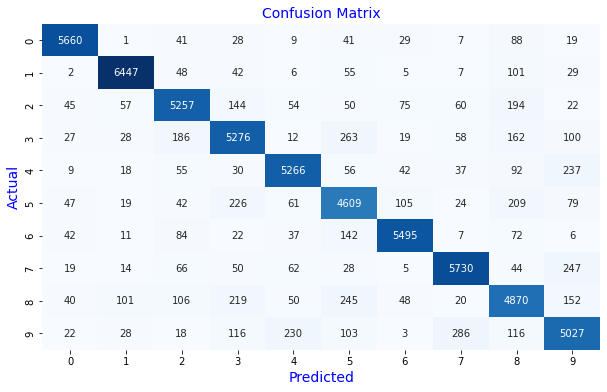

In [42]:
## Confusion Matrix
confmat_sgd_2 = confusion_matrix(y_train, y_pred_sgd_valid_2)
print('confmat_sgd_2 =>\n', confmat_sgd_2)

print('--'*30)

## Plotting as a HeatMap
plt.figure(figsize=(10, 6))
sns.heatmap(confmat_sgd_2, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')
plt.xlabel('Predicted', fontsize=14, color='b')
plt.ylabel('Actual', fontsize=14, color='b')
plt.title('Confusion Matrix', fontsize=14, color='b')
plt.show()

In [43]:
## Precision and Recall score
precison_score_sgd_2 = precision_score(y_train, y_pred_sgd_valid_2, average='macro')
print('Precison Score using SGD using Macro Averaging =>', precison_score_sgd_2)

precison_score_sgd_2 = precision_score(y_train, y_pred_sgd_valid_2, average='micro')
print('Precison Score using SGD using Micro Averaging =>', precison_score_sgd_2)

precison_score_sgd_2 = precision_score(y_train, y_pred_sgd_valid_2, average='weighted')
print('Precison Score using SGD using Weighted Averaging =>', precison_score_sgd_2)

## The same for Recall and F1_score and other Metrics and also classification report

## ------- take your time understanding every thing carefully

Precison Score using SGD using Macro Averaging => 0.8928481961210588
Precison Score using SGD using Micro Averaging => 0.89395
Precison Score using SGD using Weighted Averaging => 0.8943897998096211


* > `After getting all you want, choose the Final Model, finsih Tuning your Model, Then you will evaluate on Test set`

### `Evaluation on Test set`

In [44]:
## Let's imagine that we choose the sgd_clf_2 ---> This is our Model
## Evaluate on test set
y_pred_test = sgd_clf_2.predict(X_test)

In [45]:
## Concatenate the Result with its indecies and all in DF
df_test_final = pd.DataFrame(np.c_[X_test.index, y_pred_test], columns=['Index', 'Prediction'])
df_test_final

,Index,Prediction
0,60000,7
1,60001,2
2,60002,1
3,60003,0
4,60004,4
...,...,...
9995,69995,2
9996,69996,3
9997,69997,4
9998,69998,5


### `More Details Later -- Thanks`